# KSS Decision Neighborhood

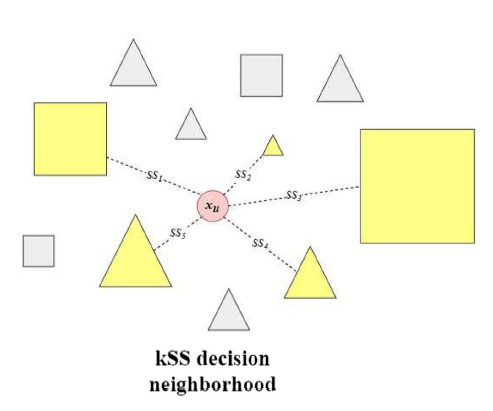

KSS algorithm is based on the k-Nearest Neighbor (kNN) algorithm and inspired
by the Isaac Newton’s Law of Universal Gravitation. 

Accordingly, it defines the attraction force or strength between two any objects as being directly proportional to the product of their masses or relevance, and inverselY proportional to the square of their distance. 

## Código

Librerías necesarias

In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from heapq import nlargest
import math
import random

`compute_cosine_similarity`: Esta función calcula la similitud del coseno entre dos vectores. La similitud del coseno es una medida de la similitud entre dos vectores no nulos, que mide el coseno del ángulo entre ellos. El valor oscila entre -1 y 1, siendo 1 el valor cuando los vectores son idénticos y -1 cuando son completamente opuestos.

In [2]:
# Compute cosine similarity between two vectors
def compute_cosine_similarity(vec1, vec2):
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

compute_distance: Esta función calcula la distancia entre dos vectores utilizando la similitud del coseno. La distancia se define como 1 menos la similitud del coseno. El resultado varía entre 0 y 2, siendo 0 cuando los vectores son idénticos y 2 cuando son completamente opuestos.

In [3]:
# Compute distance between two vectors using cosine similarity
def compute_distance(vec1, vec2):
    return 1 - compute_cosine_similarity(vec1, vec2)

`calculate_strength`: Esta función calcula la fuerza entre dos objetos basada en sus masas y distancia. La fórmula es (m(xu) * m(xi)) / dist(xu, xi)^2, donde m(xu) y m(xi) representan las masas (relevancia) de los objetos xu y xi, y dist(xu, xi) representa la distancia entre ellos en un espacio de características dado.


In [4]:
# Calculate strength between two objects based on their masses and distance
def calculate_strength(vec_u, vec_i, mass_u, mass_i):
    distance = compute_distance(vec_u, vec_i)
    if distance == 0:
        return 0
    return (mass_u * mass_i) / (distance ** 2)


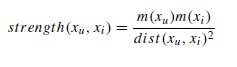

`k_strongest_strengths`: Esta función encuentra las k fuerzas más fuertes para un objeto dado en un conjunto de datos. Dado un conjunto de datos con masas y características, un vector objetivo y su masa, y un valor k, la función devuelve los índices de las k fuerzas más fuertes en el conjunto de datos.


In [30]:
# Find the k strongest strengths for a given object in a dataset
def k_strongest_strengths(dataset, target_vector, target_mass, k):
    masses = dataset["masses"]
    features = dataset["features"]
    strengths = []

    for i, feature_vector in enumerate(features):
        strength = calculate_strength(target_vector, feature_vector, target_mass, masses[i])
        strengths.append((i, strength))

    return nlargest(k, strengths, key=lambda x: x[1])

In [31]:
# Find the k strongest strengths for a given object in a dataset
# def k_strongest_strengths(features, masses, target_vector, target_mass, k):
#     strengths = [calculate_strength(target_mass, mass, target_vector, feature) for mass, feature in zip(masses, features)]
#     k_strongest = sorted(strengths, reverse=True)[:k]
#     return k_strongest


### Fórmula de clasificación

In [6]:
# Define a function to calculate δ(c, xi)
def delta(c, xi, category_labels):
    return 1 if category_labels[xi] == c else 0

La función `predict_class_kss` tiene como objetivo predecir la clase de un objeto no etiquetado utilizando el algoritmo de k Strongest Strengths. La función toma como entrada un conjunto de datos (dataset), las etiquetas de categoría de las instancias en el conjunto de datos, un vector objetivo (instancia no etiquetada), la masa del vector objetivo y el número 'k' de instancias con la mayor fuerza.

In [7]:
# Define a function to predict the class of an unlabeled instance using the k Strongest Strengths algorithm
def predict_class_kss(dataset, category_labels, target_vector, target_mass, k):
    k_strongest = k_strongest_strengths(dataset, target_vector, target_mass, k)
    categories = set(category_labels)
    
    category_scores = {}

    for category in categories:
        score = 0
        for index, _ in k_strongest:
            score += delta(category, index, category_labels) # Add strength if xi belongs to category c
        category_scores[category] = score

    return max(category_scores, key=category_scores.get)


Primero, la función calcula las k fuerzas más fuertes entre el vector objetivo y las instancias del conjunto de datos. Luego, se crea un conjunto único de categorías y un diccionario para almacenar la puntuación de cada categoría. La función itera sobre cada categoría y suma la fuerza de las instancias en el conjunto de k fuerzas más fuertes que pertenecen a la categoría actual. Al final, la función selecciona la categoría con la puntuación más alta como la clase predicha para el objeto no etiquetado.

In [8]:
# Example dataset
dataset = {
    "masses": [1, 2, 1, 3, 1, 1],
    "features": [
        np.array([1, 2, 3]),
        np.array([4, 5, 6]),
        np.array([1, 3, 5]),
        np.array([6, 5, 4]),
        np.array([2, 4, 6]),
        np.array([1, 1, 1]),
    ],
}

# Example dataset with category labels
category_labels = ['A', 'A', 'B', 'B', 'A', 'B']

# Example target object
target_vector = np.array([5, 6, 7])
target_mass = 2

# Find the 3 strongest strengths
k = 3

# Predict the class of the target object using the k Strongest Strengths algorithm
predicted_class = predict_class_kss(dataset, category_labels, target_vector, target_mass, k)
print(predicted_class)


B


### OCC-kSS algorithm

`calculate_strg`: Esta función calcula la fuerza objetivo Strg(xu) para un objeto no etiquetado xu. Strg(xu) se define como la fuerza entre xu y el objeto de entrenamiento SS1(xu) que ejerce la mayor fuerza sobre xu.

In [9]:
# Calculate Strg(xu)
def calculate_strg(xu, dataset):
    k_strongest = k_strongest_strengths(dataset, xu, target_mass, 1)
    ss1_xu = dataset["features"][k_strongest[0][0]]
    return calculate_strength(xu, ss1_xu, target_mass, dataset["masses"][k_strongest[0][0]])


calculate_sref: Esta función calcula la fuerza de referencia Sref(SS1(xu)) para el objeto de entrenamiento SS1(xu) que ejerce la fuerza más fuerte sobre xu. Sref(SS1(xu)) se define como la media de las fuerzas entre SS1(xu) y los k objetos de entrenamiento que ejercen las fuerzas más fuertes sobre SS1(xu).


In [10]:
# Calculate Sref(SS1(xu))
def calculate_sref(ss1_xu, dataset, k):
    k_strongest = k_strongest_strengths(dataset, ss1_xu, target_mass, k)
    total_strength = sum(calculate_strength(ss1_xu, dataset["features"][index], target_mass, dataset["masses"][index]) for index, _ in k_strongest)
    return total_strength / k


`classify_unlabeled_object`: Esta función clasifica un objeto sin etiquetar xu en función de sus fuerzas objetivo y de referencia, y de un umbral β predefinido. Si la relación entre Strg(xu) y Sref(SS1(xu)) es mayor o igual que β, el objeto se clasifica como positivo (1); de lo contrario, se clasifica como negativo (0).

In [11]:
# Classify xu based on Strg(xu) and Sref(SS1(xu))
def classify_unlabeled_object(xu, dataset, target_mass, k, beta_threshold):
    ss1_xu_index = k_strongest_strengths(dataset, xu, target_mass, 1)[0][0]
    ss1_xu = dataset["features"][ss1_xu_index]
    strg_xu = calculate_strg(xu, dataset)
    sref_ss1_xu = calculate_sref(ss1_xu, dataset, k)
    
    return 1 if strg_xu / sref_ss1_xu >= beta_threshold else 0

### Global Strength Classifier (gSC)

`calculate_strg_gsc`: Esta función calcula la fuerza objetivo Strg(xu) para un objeto sin etiquetar xu en el algoritmo gSC. Strg(xu) se define como la fuerza promedio ejercida sobre xu por todas las muestras de entrenamiento en el conjunto de datos.

In [12]:
# Calculate Strg(xu) for gSC
def calculate_strg_gsc(xu, dataset):
    total_strength = sum(calculate_strength(xu, dataset["features"][i], target_mass, dataset["masses"][i]) for i in range(len(dataset["masses"])))
    return total_strength / len(dataset["masses"])

`calculate_sref_gsc`: Esta función calcula la fuerza de referencia global Sref(X) para el conjunto de datos de objetos de entrenamiento pertenecientes a la clase objetivo. Sref(X) se define como la fuerza promedio con la que las muestras de entrenamiento en el conjunto de datos se atraen entre sí, excluyendo la autoatracción.

In [13]:
# Calculate Sref(X) for gSC
def calculate_sref_gsc(dataset):
    n = len(dataset["masses"])
    total_strength = sum(calculate_strength(dataset["features"][i], dataset["features"][j], dataset["masses"][i], dataset["masses"][j]) for i in range(n) for j in range(n) if i != j)
    return total_strength / (n * (n - 1))


`classify_unlabeled_object_gsc`: Esta función clasifica un objeto sin etiquetar xu en función de su fuerza objetivo y la fuerza de referencia global, así como un umbral β predefinido. Si la proporción de Strg(xu) a Sref(X) es mayor o igual a β, el objeto se clasifica como positivo (1); de lo contrario, se clasifica como negativo (0).

In [14]:
# Classify xu based on Strg(xu) and Sref(X) for gSC
def classify_unlabeled_object_gsc(xu, dataset, target_mass, beta_threshold):
    strg_xu = calculate_strg_gsc(xu, dataset)
    sref_x = calculate_sref_gsc(dataset)
    
    return 1 if strg_xu / sref_x >= beta_threshold else 0


### Adapting for Mental Health Detection tasks

Para adaptar los algoritmos a las tareas de detección de salud mental, tendremos que calcular la masa o relevancia de cada documento o mensaje basandonos en la fórmula proporcionada.

`calculate_mass`: Esta función calcula la masa de un documento d basándose en las apariciones de términos relacionados con un trastorno de salud mental específico. La masa se define como la proporción del contenido en el documento relacionado con el trastorno. Los documentos con más términos relacionados con el trastorno tendrán una mayor masa.

In [15]:
def calculate_mass(d, lexicon):
    term_occurrences = sum(d.count(wi) for wi in lexicon)
    document_length = len(d.split())
    mass = (1 + term_occurrences) / (1 + document_length)
    return mass

Ahora, implementaremos el método basado en datos (DB) en código:

`calculate_tf`: Esta función calcula la frecuencia de término TF(wi) para una palabra dada wi en las frases personales del conjunto de documentos de entrenamiento D.

In [16]:
def calculate_tf(wi, pp_d):
    occurrences = sum(phrase.count(wi) for phrase in pp_d)
    return math.log(1 + occurrences)

calculate_idf: Esta función calcula la frecuencia inversa de documento IDF(wi) para una palabra dada wi en el léxico de referencia Leng.

In [17]:
def calculate_idf(wi, leng):
    rank_wi = leng.index(wi) if wi in leng else len(leng)
    return math.log(len(leng) / (len(leng) - rank_wi + 1))


`calculate_rel`: Esta función calcula la relevancia de dominio rel(wi) para una palabra dada wi utilizando los valores de TF(wi) e IDF(wi).


In [18]:
def calculate_rel(wi, pp_d, leng):
    tf = calculate_tf(wi, pp_d)
    idf = calculate_idf(wi, leng)
    return tf * idf


`create_db_lexicon`: Esta función crea el léxico DB calculando la relevancia de dominio para cada palabra en el vocabulario y seleccionando las palabras con mayor relevancia de dominio.

In [22]:
def create_db_lexicon(v_d, pp_d, leng, top_n=10):
    rel_scores = [(wi, calculate_rel(wi, pp_d, leng)) for wi in v_d]
    sorted_rel_scores = sorted(rel_scores, key=lambda x: x[1], reverse=True)
    return [wi for wi, score in sorted_rel_scores[:top_n]]

## Experimentos

Introducimos algunas palabras relacionadas a depresión y desordenes alimenticios.

### Depresión

In [25]:
messages_depression = [
"No puedo dejar de sentirme deprimido y solo.",
"Nada parece hacerme feliz últimamente.",
"Me siento tan desesperanzado y vacío por dentro.",
"Constantemente me siento inútil y lleno de culpa.",
"La ansiedad me abruma todos los días.",
"Siempre estoy triste y no sé por qué."
]

In [26]:
lexicon_depression = ['triste', 'desesperanzado', 'deprimido', 'ansiedad', 'solitario', 'inútil', 'vacío', 'culpa', 'suicida', 'harto']

In [ ]:
# Let's create a sample message and calculate its mass
sample_message = "Me siento triste y con ansiedad todo el tiempo"
depression_lexicon = [word for word in lexicon_depression]

message_mass = calculate_mass(sample_message, depression_lexicon)

# Apply the OCC_kSS algorithm for classification
k = 3
beta = 0.8

#Define the dataset
training_messages = messages_depression
training_masses = [calculate_mass(message, depression_lexicon) for message in training_messages]

dataset_depression = {
    "features": training_messages,
    "masses": training_masses
}
class_result = classify_unlabeled_object(sample_message, training_messages, training_masses, k, beta)

print(f"Classification result: {class_result}")

### Trastornos alimenticios

In [ ]:
messages_eating_disorders = [
"Me siento tan gorda, no quiero comer nada hoy.",
"No puedo dejar de pensar en las calorías que consumí.",
"Tengo miedo de subir de peso si como normalmente.",
"Me siento tan mal cuando como en exceso.",
"Siento que no tengo control sobre mis atracones.",
"Me obsesiona la idea de tener un cuerpo perfecto."
]

lexicon_eating_disorders = ['exceso', 'perfecto', 'atracones', 'dieta', 'peso', 'calorías', 'hambre', 'restricción', 'cuerpo', 'imagen']

In [ ]:
# Let's create a sample message and calculate its mass
sample_message = "Me siento fatal cuando como demasiado."
depression_lexicon = [word for word in lexicon_depression]

message_mass = calculate_mass(sample_message, depression_lexicon)

# Apply the OCC_kSS algorithm for classification
k = 3
beta = 0.8

#Define the dataset
training_messages = messages_depression
training_masses = [calculate_mass(message, depression_lexicon) for message in training_messages]

dataset_depression = {
    "features": training_messages,
    "masses": training_masses
}
class_result = classify_unlabeled_object(sample_message, training_messages, training_masses, k, beta)

print(f"Classification result: {class_result}")